<a href="https://colab.research.google.com/github/sid-nadella12/IC-CAP-python/blob/master/voffprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
data = pd.read_table("/content/drive/My Drive/IDVG_AllVoff.txt") 
	# print(data)
table_data = np.asarray(data)

In [0]:
new_table = np.zeros((16441, 3))

for vo in range(401):
	for i in range(41):
		new_table[41*vo + i][0], new_table[41*vo +i][1] = -4.00 + vo*0.01, (-4.0 + i*0.1) 
		new_table[41*vo + i][2] = table_data[i][vo + 1]

	# print(new_table)
new_table[:,1] = np.around(new_table[:,1], decimals=1)
df = pd.DataFrame(new_table)
	# print(df)
df.rename(columns={0: 'voff'}, inplace=True)
df.rename(columns={1: 'vg'}, inplace=True)
df.rename(columns={2: 'ids'}, inplace=True)

In [0]:
df

,voff,vg,ids
0,-4.0,-4.0,1.139400
1,-4.0,-3.9,2.332090
2,-4.0,-3.8,3.789230
3,-4.0,-3.7,5.400230
4,-4.0,-3.6,7.131340
...,...,...,...
16436,0.0,-0.4,0.000454
16437,0.0,-0.3,0.005877
16438,0.0,-0.2,0.062972
16439,0.0,-0.1,0.377698


In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc2


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [0]:
dataset = df.copy()
dataset.tail()

,voff,vg,ids
16436,0.0,-0.4,0.000454
16437,0.0,-0.3,0.005877
16438,0.0,-0.2,0.062972
16439,0.0,-0.1,0.377698
16440,0.0,0.0,1.139400


In [0]:
dataset.isna().sum()

voff    0
vg      0
ids     0
dtype: int64

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset
test_dataset

,voff,vg,ids
0,-4.0,-4.0,1.139400e+00
13,-4.0,-2.7,2.483820e+01
21,-4.0,-1.9,4.163470e+01
25,-4.0,-1.5,5.017870e+01
26,-4.0,-1.4,5.232610e+01
...,...,...,...
16412,0.0,-2.8,5.023400e-11
16414,0.0,-2.6,5.023400e-11
16418,0.0,-2.2,5.023400e-11
16427,0.0,-1.3,5.022900e-11


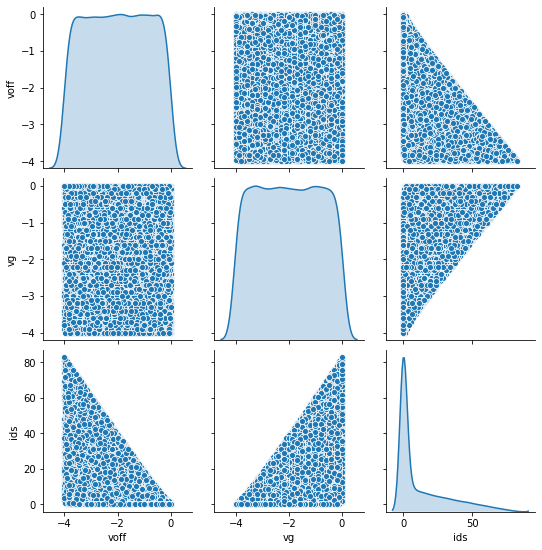

In [0]:
sns.pairplot(train_dataset[["voff", "vg", "ids"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("voff")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
vg,13153.0,-2.007078,1.182340,-4.000000e+00,-3.000000e+00,-2.000000,-1.0000,0.0000
ids,13153.0,13.143457,19.055539,5.022900e-11,5.085140e-11,0.951051,22.3692,82.7905


In [0]:
train_labels = train_dataset.pop('voff')
test_labels = test_dataset.pop('voff')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = normed_train_data[:10]
example_result =np.around(model.predict(example_batch), decimals=2)
example_result

array([[-0.26],
       [-0.37],
       [-0.27],
       [-0.25],
       [-0.18],
       [-0.36],
       [-0.29],
       [-0.25],
       [-0.2 ],
       [-0.29]], dtype=float32)

In [0]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7460,  mae:0.6283,  mse:0.7461,  val_loss:0.4203,  val_mae:0.4496,  val_mse:0.4181,  
....................................................................................................
Epoch: 100, loss:0.3163,  mae:0.3372,  mse:0.3163,  val_loss:0.3269,  val_mae:0.3465,  val_mse:0.3226,  
....................................................................................................
Epoch: 200, loss:0.3173,  mae:0.3330,  mse:0.3173,  val_loss:0.3161,  val_mae:0.3284,  val_mse:0.3126,  
....................................................................................................
Epoch: 300, loss:0.3169,  mae:0.3299,  mse:0.3169,  val_loss:0.3233,  val_mae:0.3288,  val_mse:0.3191,  
....................................................................................................
Epoch: 400, loss:0.3105,  mae:0.3273,  mse:0.3105,  val_loss:0.3494,  val_mae:0.3454,  val_mse:0.3437,  
........................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.302556,0.317493,0.302608,0.300925,0.322277,0.298254,995
996,0.303920,0.319612,0.303944,0.311568,0.337153,0.309716,996
997,0.306585,0.319252,0.306520,0.315637,0.326129,0.314312,997
998,0.303765,0.318349,0.303764,1.085584,0.588078,1.069569,998
999,0.303909,0.317847,0.303851,0.352592,0.341633,0.346344,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'voff')

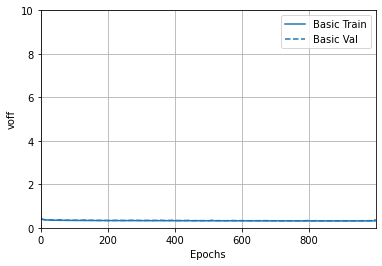

In [0]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('voff')

Text(0, 0.5, 'voff')

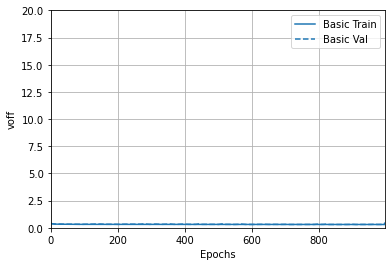

In [0]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('voff')

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7776,  mae:0.6410,  mse:0.7778,  val_loss:0.4033,  val_mae:0.4226,  val_mse:0.3992,  
..........................................................................

Text(0, 0.5, 'voff')

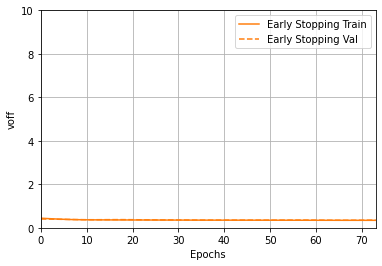

In [0]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('voff')

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} voff".format(mae))

103/103 - 0s - loss: 0.3053 - mae: 0.3360 - mse: 0.3029
Testing set Mean Abs Error:  0.34 voff


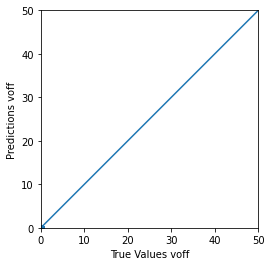

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values voff')
plt.ylabel('Predictions voff')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


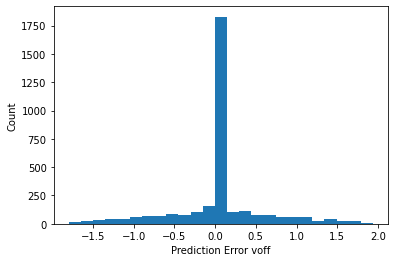

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error voff")
_ = plt.ylabel("Count")

In [0]:
test_predictions


array([-3.334733  , -3.9315398 , -3.912842  , ..., -1.0210804 ,
       -0.6236445 , -0.06114027], dtype=float32)

In [0]:
# x = [-3.6, 7.131340]
model.predict([-3.6, 7.131340])

ValueError: ignored